# __Credit Card Customer Segmentation with K-Means__

We are playing the role of a credit card company. We have a dataset with information on the company's clients, and we want to segment them into different groups in order to apply different business strategies for each type of customer.

For instance, the company could provide higher credit limits for customers that use the card a lot, but spend little money, or even create incentives for those with high income who don't use the card as much as the company expects. In order to apply different strategies, the company needs different groups of customers.

Luckily, the data engineering team has already cleaned most of the data so we can focus on building the best possible model to segment the data. Also, in a planning meeting with the Data Science coordinator, it was decided that we should use the K-means algorithm to segment the data.

In order to use the algorithm properly and achieve all the goals that the company has set for us, we'll go through the following steps:

- Analyze the dataset
- Prepare the data for modeling
- Find an appropriate number of clusters
- Segment the data
- Interpret and explain the results

The variables available to us:

- `customer_id`: unique identifier for each customer
- `age`: customer age in years
- `gender`: customer gender (M or F)
- `dependent_count`: number of dependents of each customer
- `education_level`: level of education ("High School", "Graduate", etc.)
- `marital_status`: marital status ("Single", "Married", etc.)
- `estimated_income`: the estimated income for the customer projected by the data science team
- `months_on_book`: time as a customer in months
- `total_relationship_count`: number of times the customer contacted the company
- `months_inactive_12_mon`: number of months the customer did not use the credit card in the last 12 months
- `credit_limit`: customer's credit limit
- `total_trans_amount`: the overall amount of money spent on the card by the customer
- `total_trans_count`: the overall number of times the customer used the card
- `avg_utilization_ratio`: daily average utilization ratio

We can now import our dataset and packages we anticipate we'll use:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
#style.use('fivethirtyeight')
%matplotlib inline

customers = pd.read_csv('customer_segmentation.csv')

In [2]:
print(f'The dataset has {customers.shape[0]} rows and {customers.shape[1]} columns\n\n')

customers.info(memory_usage = False)

The dataset has 10127 rows and 14 columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_r

In [3]:
customers.describe()

,customer_id,age,dependent_count,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,62078.206774,35.928409,3.812580,2.341167,8631.953698,4404.086304,64.858695,0.274894
std,3.690378e+07,8.016814,1.298908,39372.861291,7.986416,1.554408,1.010622,9088.776650,3397.129254,23.472570,0.275691
min,7.080821e+08,26.000000,0.000000,20000.000000,13.000000,1.000000,0.000000,1438.300000,510.000000,10.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,32000.000000,31.000000,3.000000,2.000000,2555.000000,2155.500000,45.000000,0.023000
50%,7.179264e+08,46.000000,2.000000,50000.000000,36.000000,4.000000,2.000000,4549.000000,3899.000000,67.000000,0.176000
75%,7.731435e+08,52.000000,3.000000,80000.000000,40.000000,5.000000,3.000000,11067.500000,4741.000000,81.000000,0.503000
max,8.283431e+08,73.000000,5.000000,200000.000000,56.000000,6.000000,6.000000,34516.000000,18484.000000,139.000000,0.999000


In [4]:
customers['education_level'].value_counts()

Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: education_level, dtype: int64

In [5]:
customers['marital_status'].value_counts()

Married     4687
Single      3943
Unknown      749
Divorced     748
Name: marital_status, dtype: int64

### Initial Observations:

- __We could discard the `customer_id` column__


In [6]:
customers = customers.drop(columns = ['customer_id'], axis = 0)

- __We have 10127 rows with 14 columns (13 after removing customer id)__
- __There are three columns of object type:__
    - `gender`: we will replace 'M' with 1 and 'F' with 0
    - `marital_status`: split between Single, Married, Divorced and Unknown (might want to drop Unknown)
    - `education_level`: six different tiers, with majority having a Graduate level or more
- __No missing values__

Now we can try plotting the correlation values that are higher than 0.3 and the distributions of numerical columns:

<AxesSubplot:>

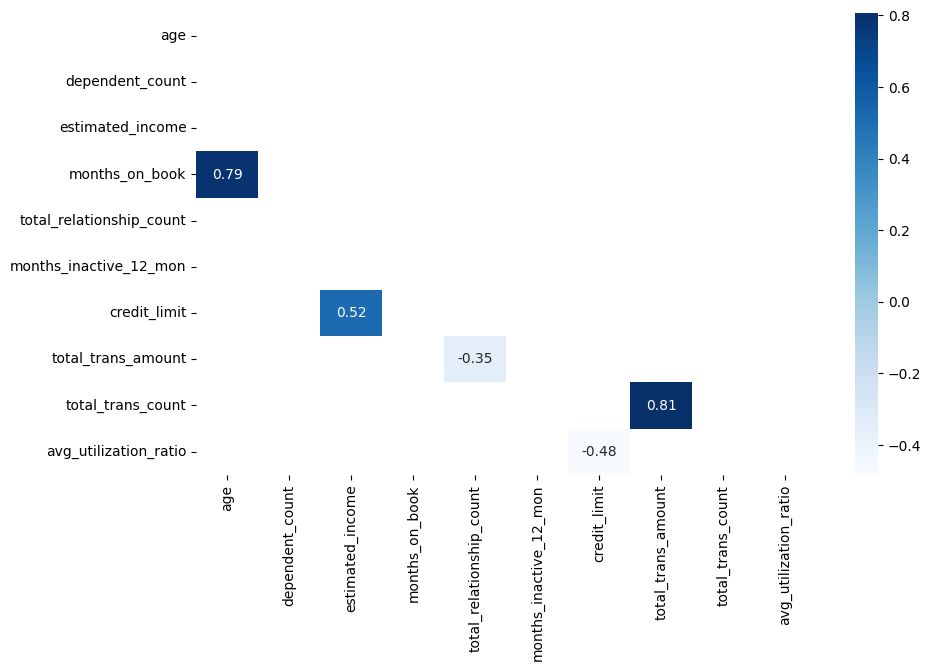

In [7]:
correlations = customers.corr()
mask = np.triu(np.ones_like(correlations, dtype=bool))
plt.figure(figsize=(10,6))
sns.heatmap(correlations[abs(correlations) >= 0.3], mask = mask, annot=True, cmap="Blues")

__High Correlations__:
- __The higher the age, the more months on book__
- __Credit limit is positively correlated with the estimated income and negatively correlated with the average utilization ratio__
- __The amount of times a customer contacted the company is inversely related to the amount spent__
- __Logically, higher amounts of transactions are strongly correlated with higher amounts spent__

/tmp/ipykernel_94/432989190.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  customers.hist(ax = ax, grid = False, xlabelsize = 10, ylabelsize = 10)


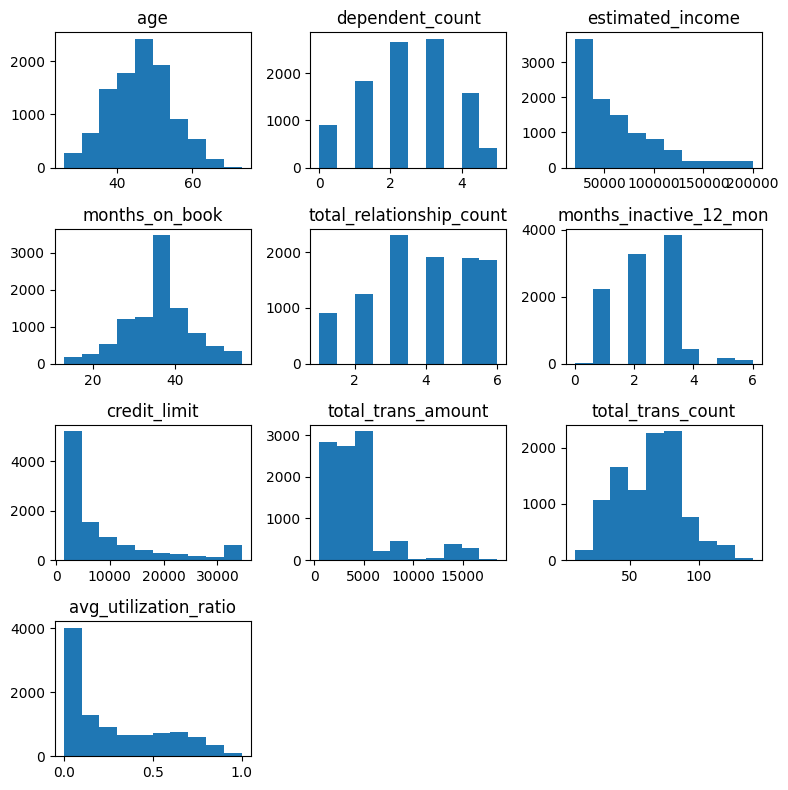

In [8]:
fig, ax = plt.subplots(figsize = (8,8))
customers.hist(ax = ax, grid = False, xlabelsize = 10, ylabelsize = 10)
plt.tight_layout()
plt.show()

__Distributions:__
- __Most customers have low incomes and don't spend more than 3 months inactive__
- __Most have at least 1 dependent and are at least 40 years old__
- __Vast majority has a credit limit lower than $5000, so it makes sense most transactions don't exceed that amount__
- __Most customers keep their utilization ratio under 20%__

## __Feature Engineering__

As mentioned earlier, we have a few categorical variables that we should work through. First, let's look at `gender` and `education_level`. For `gender`, it will be simple to replace 'M' with 1 and 'F' with 0. For `education_level`, we know we have 6 distinct values. To convert these to numbers, we will assign them ranks of 0-5 while respecting their logical order. This will allow us to observe further relations between education levels and other variables.

Below, we will create a copy of our dataframe and start applying these modifications:

In [9]:
customer_clean = customers.copy()
customer_clean['gender'] = customer_clean['gender'].apply(lambda x: 1 if x == 'M' else 0)

replace_values = {'Uneducated' : 0, 'High School' : 1, 'College' : 2, 'Graduate' : 3, 'Post-Graduate' : 4, 'Doctorate' : 5}
customer_clean = customer_clean.replace({'education_level' : replace_values})

In [10]:
customer_clean['education_level'].value_counts()

3    3685
1    2351
0    1755
2    1192
4     616
5     528
Name: education_level, dtype: int64

The last categorical column left to modify is `marital_status`. Unlike `education_level`, we can't assign levels of magnitude to 'Single', 'Married' or 'Divorced. Therefore, we will create dummy variables for these:

In [11]:
customer_clean = pd.get_dummies(data = customer_clean, columns = ['marital_status'], drop_first = True)

In [12]:
customer_clean.head()

,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0


## __Scaling the Data__

Note that we have different scaled data across the DataFrame. The `estimated_income`, for instance, contains numbers in the range of dozens and hundreds of thousands, while the `dependent_count` column contains numbers from 1 to 5.

At this point of the project we need to transform the data so it's all on the same scale.

In [13]:
scaler = StandardScaler()
scaler.fit(customer_clean)
customer_scaled = scaler.transform(customer_clean)
customer_scaled = pd.DataFrame(customer_scaled, columns = customer_clean.columns)
customer_scaled.head()

,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,-0.165406,1.059956,0.503368,-0.752211,0.175810,0.384621,0.763943,-1.327136,0.446622,-0.959707,-0.973895,-0.775882,1.077338,-0.798507,-0.282609
1,0.333570,-0.943436,2.043199,0.662787,-0.967166,1.010715,1.407306,-1.327136,-0.041367,-0.916433,-1.357340,-0.616276,-0.928214,1.252337,-0.282609
2,0.583058,1.059956,0.503368,0.662787,0.785397,0.008965,0.120579,-1.327136,-0.573698,-0.740982,-1.911206,-0.997155,1.077338,-0.798507,-0.282609
3,-0.789126,-0.943436,1.273283,-0.752211,-0.636973,-0.241473,-0.522785,1.641478,-0.585251,-0.951758,-1.911206,1.759686,-0.928214,-0.798507,3.538459
4,-0.789126,1.059956,0.503368,-1.459710,0.074212,-1.869317,0.763943,-1.327136,-0.430877,-1.056263,-1.570365,-0.997155,1.077338,-0.798507,-0.282609


## __Choosing K__

With the scaling done, we now need to pick an appropriate K for our clusters, and for this we will use the inertia metric. Inertia is the sum of squared distances between data points and the clusters. Ideally, we can find a model with low inertia and low number of `k`.

To help us pick an ideal K, we will plot inertias at different k and use the Elbow Rule. As the number of k increases and inertia decreases, eventually we get to a point where the decrease in inertia becomes lower and lower for each new cluster. This forms an 'elbow'. 

Lets try fitting the model to different `k` values:

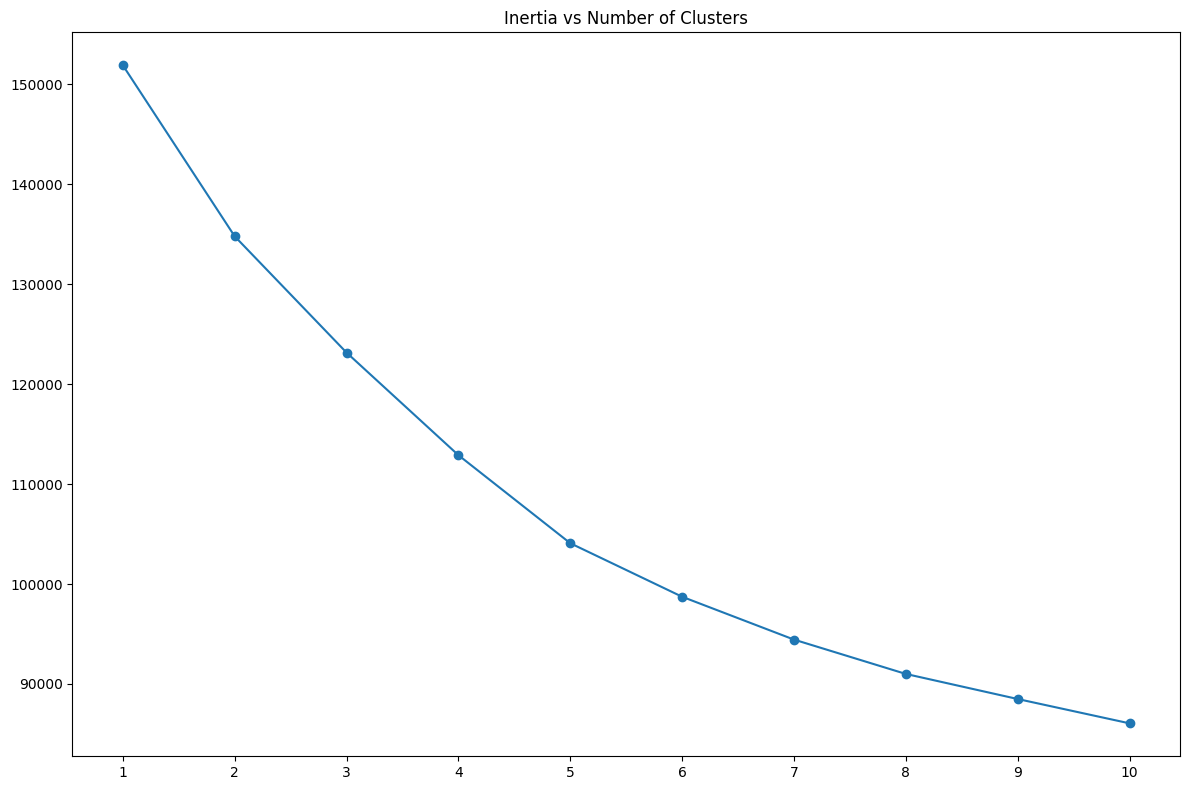

In [14]:
inertias = []
for k in range(1,11):
    kmeans = KMeans(n_clusters = k)
    result = kmeans.fit_predict(customer_scaled)
    inertias.append(kmeans.inertia_)
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), inertias, marker='o')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.title('Inertia vs Number of Clusters')

plt.tight_layout()
plt.show()

Taking the inertias from seting K between 1 and 10, we can observe that the 'elbow' forms around 5 and 7. For this exercise, we will pick k = 6. Now, we need to instantiate the model again with said k value:

In [15]:
model = KMeans(n_clusters = 6)
result = model.fit_predict(customer_scaled)
print(result)

[4 2 4 ... 0 5 0]


## __Analyzing Results__

Now it is time to analyze results. We will be able to assign each customer to a cluster, and then observe how variables change within said clusters. With that done, we can derive insights on each group and use these to give business recommendations.

In [16]:
# CREATE CLUSTER COLUMN
customers['CLUSTER'] = result + 1


In [17]:
customers.head()

,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,CLUSTER
0,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,5
1,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,3
2,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,5
3,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,6
4,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,1


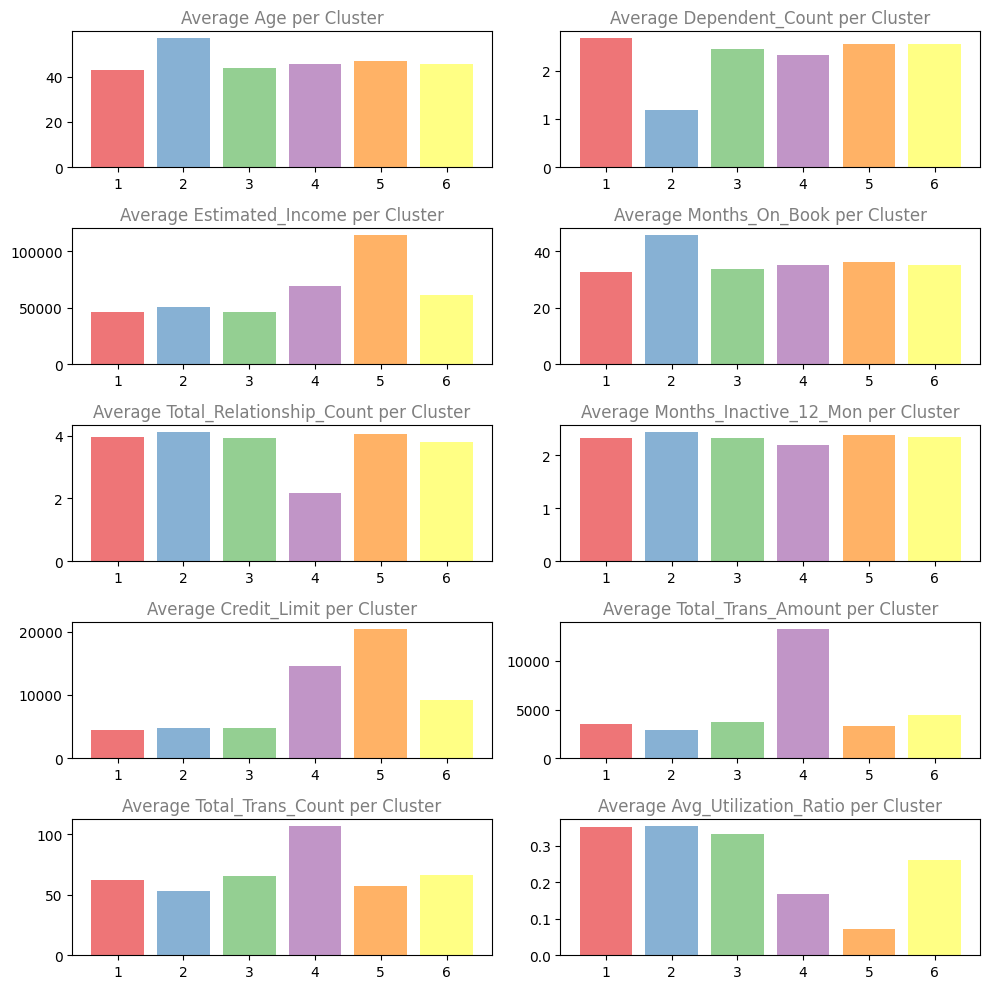

In [18]:
numeric_columns = customers.select_dtypes(include=np.number).drop(['CLUSTER'], axis=1).columns

fig = plt.figure(figsize=(10, 10))
for i, column in enumerate(numeric_columns):
    df_plot = customers.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(5, 2, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5)
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()
    

We will also take the variables with high correlation values between each other, and plot them while distinguishing each cluster to analyze the relationship between them. These variable combinations are:

- `age` and `months_on_book`
- `estimated_income` and `credit_limit`
- `credit_limit` and `avg_utilization_ratio`
- `total_trans_count` and `total_trans_amount`

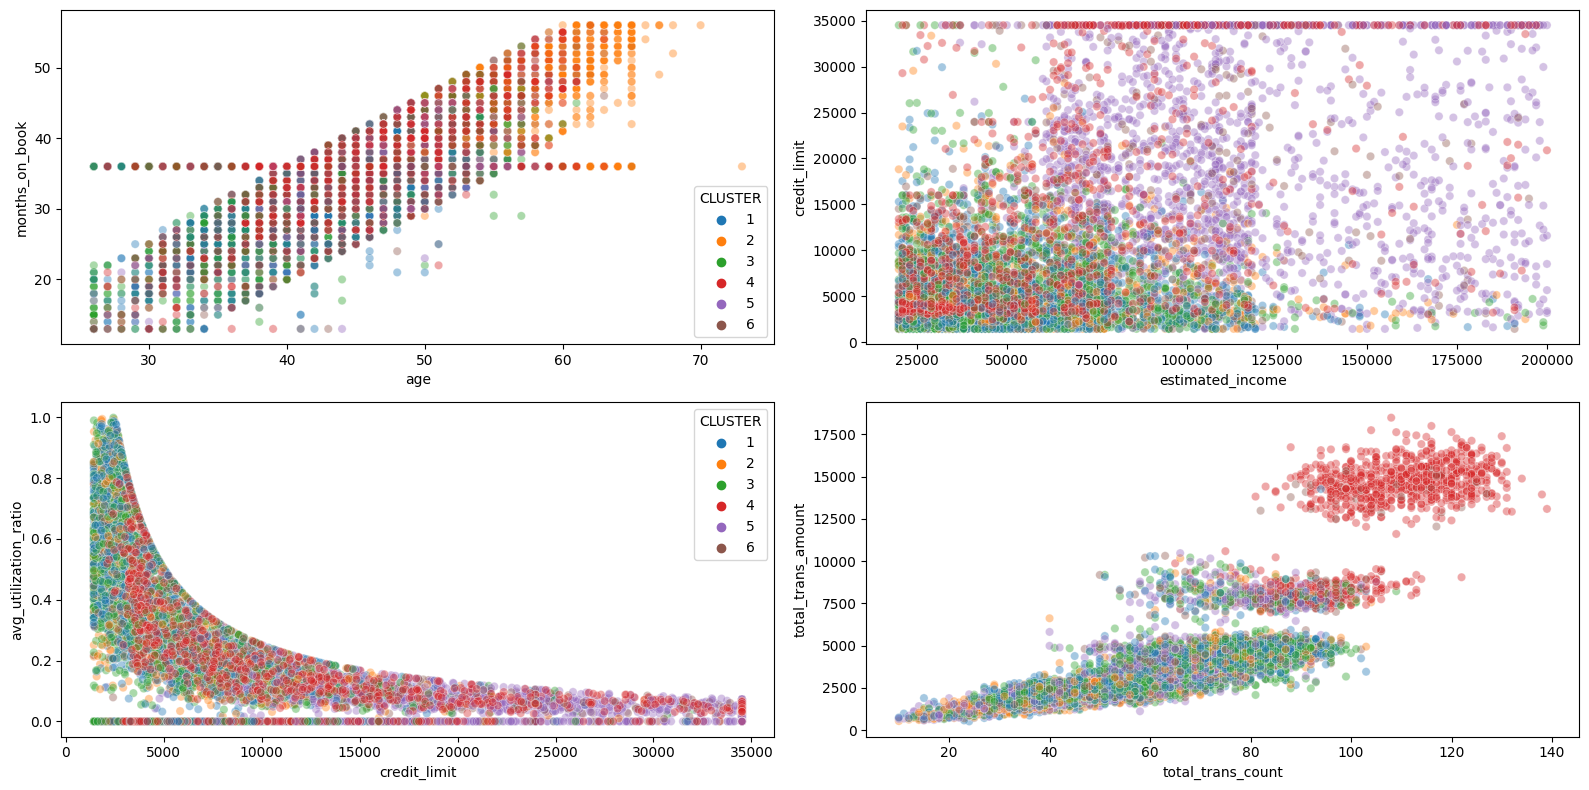

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='age', y='months_on_book', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax2, legend=False)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax4, legend=False)

plt.tight_layout()
plt.show()

### Characteristics of Numerical Columns by Cluster:

We can infer a few things from our bar charts. For instance:
- Cluster 5 has the oldest customers, alongside the lowest dependent and transaction amounts. They have also been on the books the longest.
- Cluster 4 has the highest incomes. They also have the highest credit limits, which translate into the lowest credit utilization ratios.
- Cluster 3 customers have the lowest interactions, but also spend the most and have the most transactions
- Cluster 2 has the lowest credit limit, closely followed by Clusters 1 and 5

### Percentual Distributions by Variable

We also want to ensure that certain clusters are not formed by only one type of customer. For this, we will use the `crosstab()` function in pandas to observe the percent distribution by categorical column for each cluster.

/tmp/ipykernel_94/906250918.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


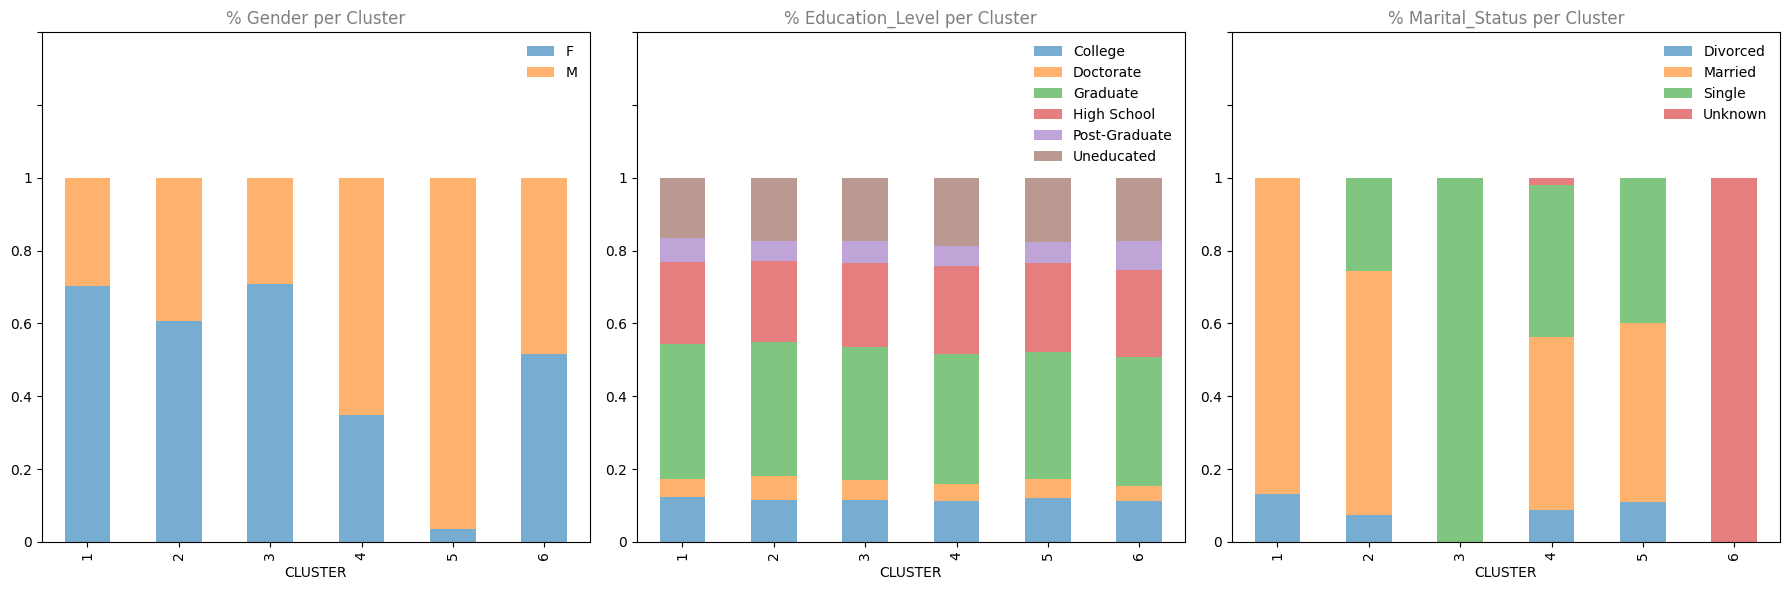

In [20]:
cat_columns = customers.select_dtypes(include=['object'])

fig = plt.figure(figsize=(18, 6))
for i, col in enumerate(cat_columns):
    plot_df = pd.crosstab(index=customers['CLUSTER'], columns=customers[col], values=customers[col], aggfunc='size', normalize='index')
    ax = fig.add_subplot(1, 3, i+1)
    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
    ax.set_title(f'% {col.title()} per Cluster', alpha=0.5)

    ax.set_ylim(0, 1.4)
    ax.legend(frameon=False)
    ax.xaxis.grid(False)
    
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax.set_yticklabels(labels)

plt.tight_layout()
plt.show()

### Characteristics of Categorical Columns by Cluster:

__Gender__: For clusters 1,2 and 6, over 60% of customers are female. However, clusters 3 and 4 have less than 40% and 5% females respectively

__Education Level__: Distributions observed are very similar for each cluster, no issue here

__Marital Status__: Clusters 3-5 seem relatively stable. However, cluster 1 is made entirely of Single customers, and all customers in cluster 6 have Unknown marital status
    - Cluster 2 is made of almost 90% Married customers
    
## __Conclusions and Recommendations__

As demanded by the company, we now have listed the most important characteristics of each cluster. We could also some suggestions and insights into each one of them.

In the end, we have the list of customers with a cluster assigned to each one.

### __Cluster 1__

__Characteristics__: Mostly men; high credit limit; high amount transitioned; high number of transactions; low utilization rate.

__Insight__: People with high volume spent on the card, but do not use it on a daily basis. Could be incentivised to spend more.

### __Cluster 2__

__Characteristics__: Mostly women; mostly married; low estimated income; low credit limit; low amount transitioned; high utilization rate.

__Insight__: Married people (majority women) with low income and limit but utilize too much of their credit with a few larger purchases

### __Cluster 3__

__Cluster 3__: Gender well divided; low credit limit, high utilization rate; marital status 100% unknown; smaller cluster.

__Insight__: Men and women with low credit limits but do have high balances.

### __Cluster 4__

__Cluster 4__: Mostly men, mostly single and married, high estimated income, high credit limit; low amount transitioned; low utilization rate.

__Insight__: People (majority men) with high income and credit limits, but don't use the card. Could be incentivized to use it.

### __Cluster 5__

__Cluster 5__: Mostly married, high age, low dependent count, long time customers, low credit limit, low amount transitioned, high utilization rate.

__Insight__: Older people and long-time customers. Low credit limit and transactions, but use the card very often. Could receive benefits to spend more money.

### __Cluster 6__

__Cluster 6__: Mostly women; 100% single people, low estimated income, low credit limit, low amount transitioned, high utilization rate.

__Insight__: Single (mostly women) people that use their card a lot but have low credit limits and income. Could be given a bit more credit limit.